In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [160]:
df = pd.read_csv('./PJME_hourly.csv')

In [161]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [162]:
from sklearn.preprocessing import MinMaxScaler

In [163]:
scaler = MinMaxScaler()

In [164]:
import datetime

In [165]:
df.shape

(145366, 2)

In [166]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [167]:
df_train = df.iloc[:116001]
df_train.shape

(116001, 2)

In [168]:
df_train.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [169]:
df_train.tail()

,Datetime,PJME_MW
115996,2015-10-06 05:00:00,21630.0
115997,2015-10-06 06:00:00,23570.0
115998,2015-10-06 07:00:00,26883.0
115999,2015-10-06 08:00:00,28450.0
116000,2015-10-06 09:00:00,28622.0


In [170]:
df_train.tail()

,Datetime,PJME_MW
115996,2015-10-06 05:00:00,21630.0
115997,2015-10-06 06:00:00,23570.0
115998,2015-10-06 07:00:00,26883.0
115999,2015-10-06 08:00:00,28450.0
116000,2015-10-06 09:00:00,28622.0


In [171]:
df_test = df.iloc[116001:]
df_test.shape

(29365, 2)

In [172]:
df_test.head()

,Datetime,PJME_MW
116001,2015-10-06 10:00:00,28588.0
116002,2015-10-06 11:00:00,28817.0
116003,2015-10-06 12:00:00,28838.0
116004,2015-10-06 13:00:00,28962.0
116005,2015-10-06 14:00:00,29169.0


In [173]:
scaler.fit(np.array(df_train["PJME_MW"]).reshape(-1, 1))
scaled_train = scaler.transform(np.array(df_train["PJME_MW"]).reshape(-1, 1))
scaled_test = scaler.transform(np.array(df_test["PJME_MW"]).reshape(-1, 1))

In [174]:
import pandas as pd
import numpy as np

def create_lstm_dataset(column, sequence_length=5):
    # data = []
    df_lstm = pd.DataFrame(columns=['t-5', 't-4', 't-3', 't-2', 't-1', 't'])
    
    # target_column = df.columns[0]  # Assuming the target column is the first column
    for index in range(len(column)):
        if(index <= 4):
            continue
        new_row = {'t-5': column[index-5] , 't-4':column[index-4], 't-3': column[index-3], 't-2': column[index-2], 't-1': column[index-1], 't': column[index]}
        df_row = pd.DataFrame(new_row, index=[0])
        df_lstm = pd.concat([df_lstm, df_row], ignore_index=True)
    
    return df_lstm


# # Example usage:
# # Assuming 'your_dataframe' is your hourly power consumption dataframe
X_y_train = create_lstm_dataset(scaled_train, sequence_length=5)
X_y_test = create_lstm_dataset(scaled_test, sequence_length=5)

In [175]:
len(X_y_train)

115996

In [176]:
len(X_y_test)

29360

In [177]:
X_train = [[[X_y_train["t-5"][index]], [X_y_train["t-4"][index]], [X_y_train["t-3"][index]], [X_y_train["t-2"][index]], [X_y_train["t-1"][index]]] for index in X_y_train.index]
y_train = X_y_train["t"]
X_test = [[[X_y_test["t-5"][index]], [X_y_test["t-4"][index]], [X_y_test["t-3"][index]], [X_y_test["t-2"][index]], [X_y_test["t-1"][index]]] for index in X_y_test.index]
y_test = X_y_test["t"]

In [178]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [179]:
import tensorflow as tf

In [180]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [181]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(5,1)))
model.add((tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add((tf.keras.layers.LSTM(16, return_sequences=False)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             16896     
                                                                 
 dropout_4 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                5184      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 22,097
Trainable params: 22,097
Non-trainable params: 0
_________________________________________________________________


In [182]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=[RootMeanSquaredError()]
              )

In [183]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[cp])

Epoch 1/10
3625/3625 [==============================] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.1145

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


3625/3625 [==============================] - 48s 11ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 2/10
3619/3625 [============================>.] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0660

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


3625/3625 [==============================] - 35s 10ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 3/10
3618/3625 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0503

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


3625/3625 [==============================] - 36s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 4/10
3617/3625 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


3625/3625 [==============================] - 35s 10ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 8.8774e-04 - val_root_mean_squared_error: 0.0298
Epoch 5/10
3616/3625 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0360

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


3625/3625 [==============================] - 35s 10ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 6.3970e-04 - val_root_mean_squared_error: 0.0253
Epoch 6/10
3619/3625 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0321

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


3625/3625 [==============================] - 36s 10ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 5.5414e-04 - val_root_mean_squared_error: 0.0235
Epoch 7/10
3616/3625 [============================>.] - ETA: 0s - loss: 9.3214e-04 - root_mean_squared_error: 0.0305

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


3625/3625 [==============================] - 35s 10ms/step - loss: 9.3205e-04 - root_mean_squared_error: 0.0305 - val_loss: 5.0406e-04 - val_root_mean_squared_error: 0.0225
Epoch 8/10
3625/3625 [==============================] - 21s 6ms/step - loss: 9.0213e-04 - root_mean_squared_error: 0.0300 - val_loss: 5.1874e-04 - val_root_mean_squared_error: 0.0228
Epoch 9/10
3625/3625 [==============================] - 21s 6ms/step - loss: 8.7128e-04 - root_mean_squared_error: 0.0295 - val_loss: 5.0743e-04 - val_root_mean_squared_error: 0.0225
Epoch 10/10
3625/3625 [==============================] - 21s 6ms/step - loss: 8.6755e-04 - root_mean_squared_error: 0.0295 - val_loss: 5.0570e-04 - val_root_mean_squared_error: 0.0225


In [184]:
import pickle

# save the model to a file
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [185]:
import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']

In [186]:
import matplotlib.pyplot as plt

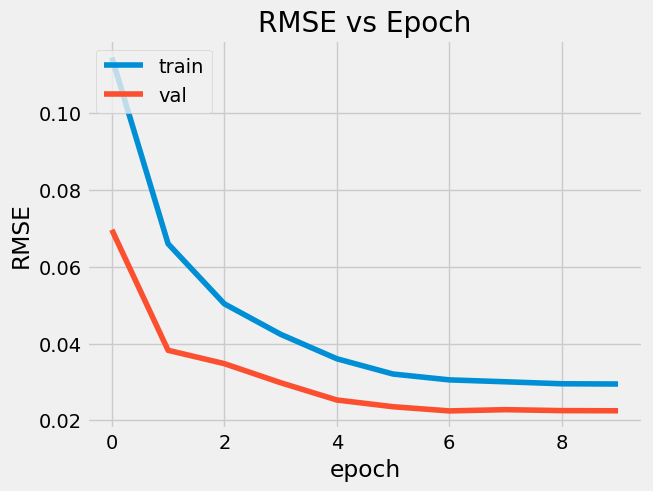

In [200]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

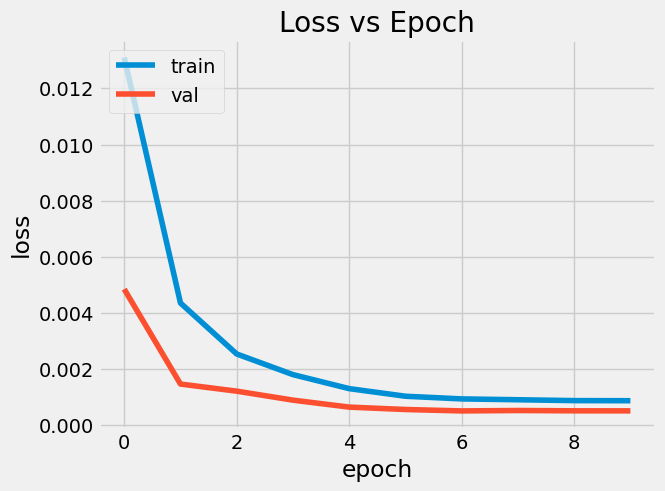

In [201]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [189]:
preds = model.predict(X_test)

918/918 [==============================] - 3s 2ms/step


In [190]:
type(y_train)

pandas.core.series.Series

In [191]:
len(X_test)

29360

In [192]:
len(X_train)

115996

In [193]:
len(preds)

29360

In [196]:
preds = [data[0] for data in preds]

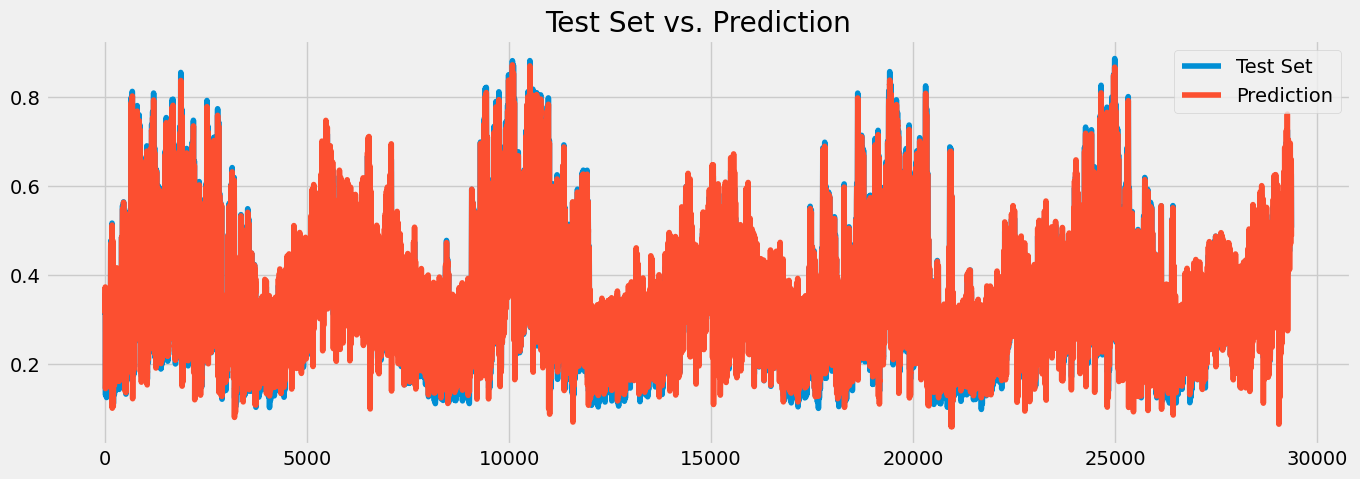

In [202]:
fig, ax = plt.subplots(figsize=(15, 5))
# y_train.plot(ax=ax, label="Training Set")
y_test.plot(ax=ax, label="Test Set")
pd.Series(list(preds)).plot(ax=ax,label="Prediction")
plt.title("Test Set vs. Prediction")
plt.legend()
plt.show()

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='Datetime', ylabel='PJME_MW'>

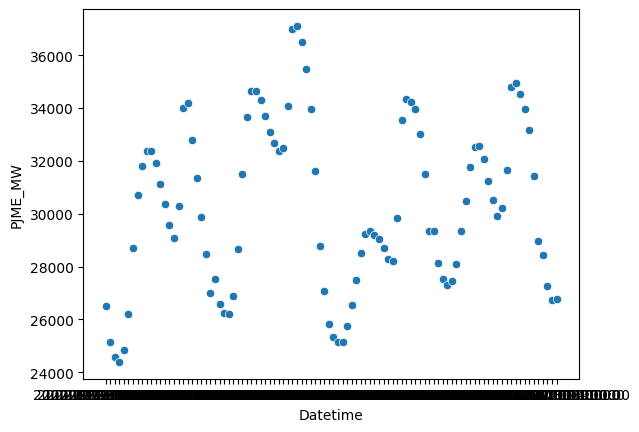

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.iloc[:100]
sns.lineplot(data=df, x=df["Datetime"], y=df["PJME_MW"])

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001FE378019E0> (for post_execute):


KeyboardInterrupt: 